## Load Modules

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array,save_img,ImageDataGenerator
from tensorflow.keras.applications.resnet_v2  import ResNet152V2
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense,Activation,Flatten,GlobalAveragePooling2D,Dropout,BatchNormalization,Conv2D,MaxPooling2D

## Tensorflow Version & GPU checking

In [2]:
tf.__version__

'2.9.0'

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12198837108260570487
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1738696295
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14990815149237471867
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


## Load Dataset

In [4]:
Train_Dir = '../../Datasets/Pneumonia/train/'
Val_Dir = '../../Datasets/Pneumonia/val/'
Test_Dir = '../../Datasets/Pneumonia/test/'

In [5]:
gen = ImageDataGenerator(rescale=1./255.0)

In [6]:
Train_Data = gen.flow_from_directory(Train_Dir,target_size=(128,128),shuffle=True,batch_size=16)
Val_Data = gen.flow_from_directory(Val_Dir,target_size=(128,128),shuffle=True,batch_size=16)
Test_Data = gen.flow_from_directory(Test_Dir,target_size=(128,128),shuffle=True,batch_size=16)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [7]:
Train_Data.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

## Model

In [8]:
Base_Model = DenseNet201(include_top=False,input_shape=(128,128,3))

74836368/74836368 [==============================] - 4s 0us/step


In [9]:
Base_Model.trainable = False

In [10]:
def classification_layer():
    Classification_Layer = [
    Flatten(),
    Dense(units=256,activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(units=128,activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(units=64,activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(units=2,activation='softmax')
    ]
    return Classification_Layer

In [11]:
model = [Base_Model]
for cls_layer in classification_layer():
    model.append(cls_layer)

In [12]:
final_model = Sequential(model)

In [13]:
final_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 4, 4, 1920)        18321984  
                                                                 
 flatten (Flatten)           (None, 30720)             0         
                                                                 
 dense (Dense)               (None, 256)               7864576   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                        

## Compile

In [14]:
callback = EarlyStopping(monitor='loss',patience=3)

In [15]:
checkpoint = ModelCheckpoint(filepath='../../Models/Pneumonia/Pneumonia_DenseNet200.hdf5',monitor='val_loss',save_best_only=True,verbose=0,mode='auto')

In [16]:
final_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

## Training

In [17]:
history = final_model.fit(Train_Data,validation_data=Val_Data,epochs=100,callbacks=[callback,checkpoint])

Epoch 1/100
326/326 [==============================] - 58s 141ms/step - loss: 0.3145 - acc: 0.8775 - val_loss: 0.1993 - val_acc: 0.9375
Epoch 2/100
326/326 [==============================] - 50s 152ms/step - loss: 0.1988 - acc: 0.9250 - val_loss: 0.4907 - val_acc: 0.7500
Epoch 3/100
326/326 [==============================] - 51s 156ms/step - loss: 0.1667 - acc: 0.9387 - val_loss: 0.1026 - val_acc: 1.0000
Epoch 4/100
326/326 [==============================] - 49s 150ms/step - loss: 0.1602 - acc: 0.9385 - val_loss: 0.3955 - val_acc: 0.8125
Epoch 5/100
326/326 [==============================] - 48s 148ms/step - loss: 0.1324 - acc: 0.9503 - val_loss: 0.7100 - val_acc: 0.6250
Epoch 6/100
326/326 [==============================] - 49s 149ms/step - loss: 0.1273 - acc: 0.9505 - val_loss: 0.4873 - val_acc: 0.7500
Epoch 7/100
326/326 [==============================] - 49s 149ms/step - loss: 0.1124 - acc: 0.9622 - val_loss: 0.1263 - val_acc: 1.0000
Epoch 8/100
326/326 [===========================

Epoch 14/100
326/326 [==============================] - 74s 226ms/step - loss: 0.0703 - acc: 0.9768 - val_loss: 0.5823 - val_acc: 0.8333

## Save Model

In [18]:
final_model.save('../../Models/Pneumonia/Penumonia_DenseNet200.h5')

## Evaluate

In [20]:
evaluation = final_model.evaluate(Test_Data)
print(f"Test Accuracy:{evaluation[1]*100:2f}%")
evaluation = final_model.evaluate(Train_Data)
print(f"Train Accuracy:{evaluation[1]*100:2f}%")

39/39 [==============================] - 5s 127ms/step - loss: 0.4567 - acc: 0.8734
Test Accuracy:87.339741%
326/326 [==============================] - 45s 138ms/step - loss: 0.1531 - acc: 0.9847
Train Accuracy:98.466259%


## Graph

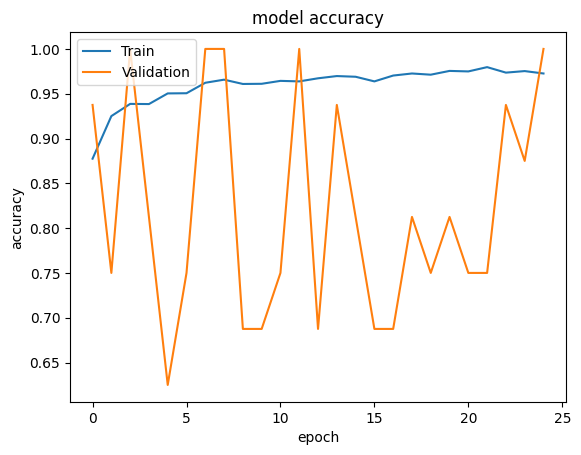

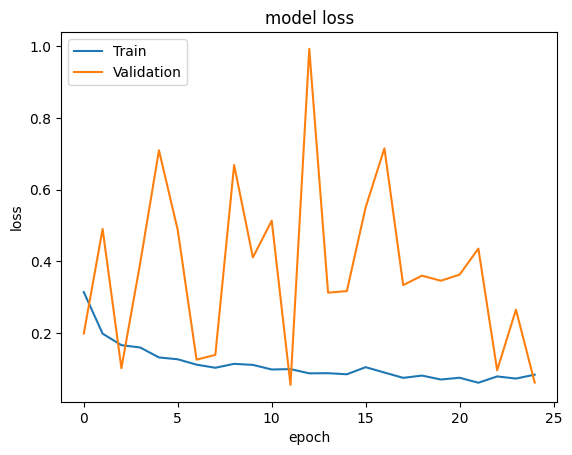

In [21]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()